In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.optimizers import Adam

import warnings
from matplotlib import MatplotlibDeprecationWarning
warnings.filterwarnings("ignore", category=MatplotlibDeprecationWarning)

Using TensorFlow backend.


<b>Problem Statement </b> <br>
You are working with a team that is developing a mobile app for doing arithmetic by hand, in Arabic. The app will recognize digits in the user's handwriting as part of its functionality. In order to use a minimum amount of data, your job as a developer is to store each hand-drawn digit using as little memory as possible. Using a dataset of hand drawn Arabic digits, you will train an autoencoder to encode and decode these images.

### Question 1A

In [2]:
# Load data into pandas dataframe
digit_pd_data = pd.read_csv('csvImages 10K x 784.csv', header=None)

# convert df to numpy array using pandas.values
digit_np_data = digit_pd_data.values

# printing shape of data
digit_np_data.shape

(10000, 784)

### Question 1B

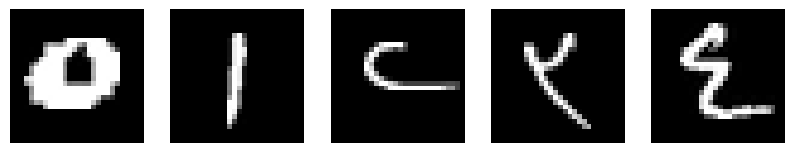

In [3]:
# normalize each value by 255
digit_np_data = digit_np_data / 255.0

# reshape the array so each image is 28 x 28 using numpy.ndarray.reshape
digit_np_data_reshaped = digit_np_data.reshape(-1, 28, 28)

# plot first 5 images using matplotlib.plot.imshow and matplotlib.plot.subplot
# 'gray' colour map. 
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(digit_np_data_reshaped[i].T, cmap='gray')
    plt.axis('off')
    
plt.show()

In [4]:
# reshape each image to be 784 (one-dimensional) for input to the neural network
digit_np_data = digit_np_data.reshape(-1, 28 **2)  
digit_np_data.shape

(10000, 784)

In [5]:
# reshape for input to convulutional autoencoder as it doesnt accept shape (10000, 784)
images = digit_np_data.reshape(-1, 28, 28, 1)  # Reshape to (10000, 28, 28, 1)

### Question 2A

In [14]:
# Use keras.layers to create an input layer that matches the dimensions of your data
input_layer = Input(shape=(28, 28, 1)) # 3D needed for CNN?

### Question 2B

In [15]:
# Use keras.layers to create an encoding stage that has at least two layers and reduces the size of the data to 50% or less 
# (less is better). You will need to choose activation functions.
hidden_encoding = Conv2D(16, (3, 3), activation='relu', padding='same',)(input_layer)
encoded = MaxPooling2D((2, 2))(hidden_encoding)

hidden_encoding2 = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
encoded2 = MaxPooling2D((2, 2))(hidden_encoding2)

### Question 2C

In [16]:
# Use keras.layers to create a decoding stage that has at least two layers and restores the data to its original size. 
# You will need to choose activation functions.
hidden_decoding = Conv2DTranspose(8, (3, 3), strides=2, activation='relu', padding='same',)(encoded2)
hidden_decoding2 = Conv2DTranspose(16, (3, 3), strides=2, activation='relu', padding='same')(hidden_decoding)

decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same',)(hidden_decoding2)

### Question 2D

In [17]:
# Compile the complete autoencoder network. 
# You will need to choose a loss function and an optimizer. 
autoencoder = Model(input_layer, decoded)
autoencoder.compile(loss='binary_crossentropy',
                   optimizer=Adam())
print(autoencoder.summary())

# Train the autoencoder using the image data.
autoencoder.fit(images, images, epochs=20, batch_size=200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 14, 14, 8)         584       
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 28, 28, 16)        1168      
__________

### Question 2E

In [18]:
# Compile an encoder network from your trained input layer and encoding stage.
encoder = Model(input_layer, encoded2)

encoded_images = encoder.predict(images[:5]).reshape(-1, 49, 8)

decoded_images = autoencoder.predict(images[:5]).reshape(-1, 28, 28)

### Question 3A

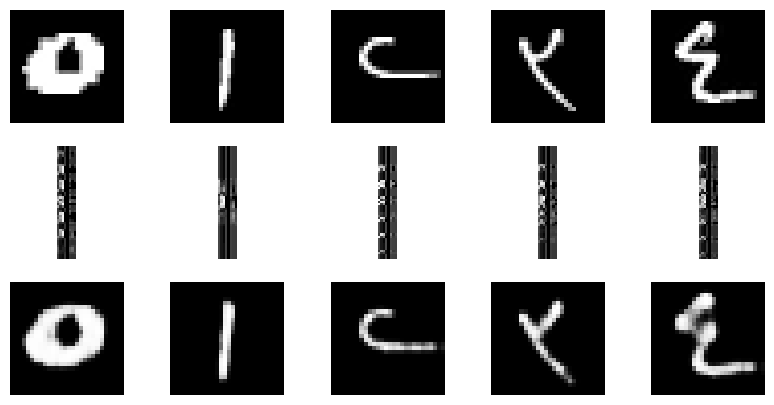

In [19]:
# Use matplotlib.plot.imshow and matplotlib.plot.subplot and your trained models to plot first five images in the top row
# encoded versions of those same images along the second row, and the decoded versions along the bottom row
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(3, 5, i+1)
    plt.imshow(digit_np_data_reshaped[i].T, cmap='gray')
    plt.axis('off')
    
    plt.subplot(3, 5, i+6)
    plt.imshow(encoded_images[i], cmap='gray')
    plt.axis('off')
    
    plt.subplot(3, 5, i+11)
    plt.imshow(decoded_images[i].T, cmap='gray')
    plt.axis('off')
    
plt.show()

Return to question 2 and adjust the hyperparameters of your model until you are able to produce decoded images that represent the original images, with an encoding that uses as little data as possible; make a record of the adjustments you try in markdown.

- Images didn't look right the first time, lost a lot of information and formed grid_like images on the decoded image
- adjusted filter numbers from 32-32-32-32 to 16-8-8-16 to help model caputure both complex and simple features
- adjusted pooling sizes for less drastic upscaling (upscaling used to go x2 to x7, adjusted sizesgo from x2 to x2)

### Question 3B

<b> Use markdown to describe how well the autoencoder is working, making reference to the plots </b> <br>
The autoencoder is working really well. The decoded images look very similar to the original images while also looking cleaner. The first picture in particular shows how the character was simplified to reduce noise and now looks smoother. The fifth image seems a little blurry, but with more epochs, the model may perform better.

### Question 3C

In [20]:
# State the amount of data needed to store a single image, 
# considering that a floating-point number is 4 bytes of data. 
s = 1 #grey-scale image
B = 4 #bytes per floating-point data
original_size = 28 * 28 * s * B
compressed_size = 49 * 8 * s * B

# Calculate how much memory will be saved as a percentage.
memory_saved = original_size - compressed_size
percentage = (memory_saved/original_size) * 100

print(f"Amount of data to store original image: {original_size} \n Amount of data to store new image: {compressed_size} \n Memory saved: {percentage}%")

Amount of data to store original image: 3136 
 Amount of data to store new image: 1568 
 Memory saved: 50.0%
